##### Importing and constant defining section:


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
# to set current working directory coherent_neutrino_scattering/ (not coherent_neutrino_scattering/vis/)
if os.getcwd()[-4:] == '/vis':
    os.chdir('../')
%matplotlib inline

from lib.config import config
import lib.coherent_neutrino_nucleus as cn
import lib.phys_constants as p_const
from lib.SpectrumInterpolator import SpectrumInterpolator
from lib.reactor import total_antineutrino_flux

Ar_N = 21
Ar_Z = 18
Ar_M = 38.964313 * p_const.ATOMIC_MASS_UNIT # MeV

################################# Reactor ##########################################################
POWER_REACTOR = 1000 * p_const.JOULE_IN_eV # MeV/s
# from "Reactor Neutrino Spectra" by Anna C. Hayes and Petr Vogel
FISSION_ENERGY_235U  = 201.7 # MeV/fission
FISSION_ENERGY_238U  = 205.0
FISSION_ENERGY_239Pu = 210.0
FISSION_ENERGY_241Pu = 212.4
# from "Reactor as a Source of Antineutrinos:Thermal Fission Energy" by V. Kopeikin, L. Mikaelyan, V. Sinev
FISSION_FRACTION_235U  = 0.59
FISSION_FRACTION_238U  = 0.07
FISSION_FRACTION_239Pu = 0.29
FISSION_FRACTION_241Pu = 0.05

### Sample Reactor Antineutrino Flux and Spectrum

Antineutrino flux from one reactor core:
$$ \frac{dF}{dE_{\nu}} = \frac{W_{th}}{\sum_i f_i E^f_i}\sum_i f_i \Big(\frac{dN}{dE_{\nu}} \Big)_i $$
$i$ - isotopes, $f_{i}$ - fission fraction of each isotope, $E^f_{i}$ - energy released per fission for isotope i

##### The antineutrino spectrums determining the total antineutrino flux emitted by the reactor

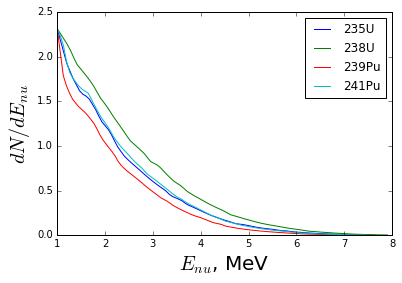

In [2]:
data_path = os.path.abspath(config['DATA_PATH'] + 'spectrum_235U.csv')
interpolator_235U = SpectrumInterpolator(data_path, 'E', 'dN_dE') #MeV

data_path = os.path.abspath(config['DATA_PATH'] + 'spectrum_238U.csv')
interpolator_238U = SpectrumInterpolator(data_path, 'E', 'dN_dE') #MeV

data_path = os.path.abspath(config['DATA_PATH'] + 'spectrum_239Pu.csv')
interpolator_239Pu = SpectrumInterpolator(data_path, 'E', 'dN_dE') #MeV

data_path = os.path.abspath(config['DATA_PATH'] + 'spectrum_241Pu.csv')
interpolator_241Pu = SpectrumInterpolator(data_path, 'E', 'dN_dE') #MeV

def make_interpolate(interpolator, number_points):
    nu_energy_range = np.linspace(interpolator.x_min, interpolator.x_max, 100) #MeV
    nu_energy_spectrum = [] 
    for i in range(nu_energy_range.size):
        probability_density = interpolator.interpolate(nu_energy_range[i])
        nu_energy_spectrum.append(probability_density)
    
    return  nu_energy_range, np.array(nu_energy_spectrum)

nu_energy_range_235U, nu_energy_spectrum_235U = make_interpolate(interpolator_235U, 100)
nu_energy_range_238U, nu_energy_spectrum_238U = make_interpolate(interpolator_238U, 100)
nu_energy_range_239Pu, nu_energy_spectrum_239Pu = make_interpolate(interpolator_239Pu, 100)
nu_energy_range_241Pu, nu_energy_spectrum_241Pu = make_interpolate(interpolator_241Pu, 100)

plt.plot(nu_energy_range_235U, nu_energy_spectrum_235U, label='235U')
plt.plot(nu_energy_range_238U, nu_energy_spectrum_238U, label='238U')
plt.plot(nu_energy_range_239Pu, nu_energy_spectrum_239Pu, label='239Pu')
plt.plot(nu_energy_range_241Pu, nu_energy_spectrum_241Pu, label='241Pu')

plt.legend()
plt.xlabel('$E_{nu}$, MeV', fontsize=20)
plt.ylabel('$ dN/dE_{nu} $', fontsize=20)

#### Total flow calculation:

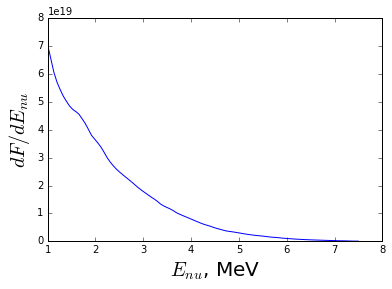

In [5]:
isotope_235U = {'FISSION_FRACTION': FISSION_FRACTION_235U, 'FISSION_ENERGY': FISSION_ENERGY_235U,
                'ENERGY_SPECTRUM': interpolator_235U.interpolate}

isotope_238U = {'FISSION_FRACTION': FISSION_FRACTION_238U, 'FISSION_ENERGY': FISSION_ENERGY_238U,
                'ENERGY_SPECTRUM': interpolator_238U.interpolate}

isotope_239Pu = {'FISSION_FRACTION': FISSION_FRACTION_239Pu, 'FISSION_ENERGY': FISSION_ENERGY_239Pu,
                'ENERGY_SPECTRUM': interpolator_239Pu.interpolate}

isotope_241Pu = {'FISSION_FRACTION': FISSION_FRACTION_241Pu, 'FISSION_ENERGY': FISSION_ENERGY_241Pu,
                'ENERGY_SPECTRUM': interpolator_241Pu.interpolate}

nu_energy_range = np.linspace(1., 7.5, 100) # MeV
reactor_antinu_flux = total_antineutrino_flux(POWER_REACTOR, 
                        [isotope_235U, isotope_238U, isotope_239Pu, isotope_241Pu], nu_energy_range)

plt.plot(nu_energy_range, reactor_antinu_flux)
plt.xlabel('$E_{nu}$, MeV', fontsize=20)
plt.ylabel('$ dF/dE_{nu} $', fontsize=20)

Total antinu flux ($s^{-1}$)

In [7]:
delta_en = nu_energy_range[1] - nu_energy_range[0]
total_flux = 0.
for i in range(nu_energy_range.size):
    total_flux += reactor_antinu_flux[i] * nu_energy_range[i]
total_flux

3.308764784686917e+21

### Kinetic energy spectrum of recoil nuclei

$$ \frac{dN}{dT} = \int dE_{\nu} \frac{dF_{\nu}}{dE_{\nu}} \frac{d\sigma(E_{\nu})}{dT} $$

Initial def:

In [4]:
nu_energy_range = np.linspace(1, 7, 100) # MeV
nucleus_max_kinetic = cn.max_kinetic_recoil_nucleus(Ar_M, nu_energy_range[nu_energy_range.size - 1]) # MeV
nucleus_kinetic_range = np.linspace(0, nucleus_max_kinetic, 100)

Loading and interpolating reactor neutrino spectrum:

In [6]:
data_path = os.path.abspath(config['DATA_PATH'] + 'mock_reactor_neutrino_spectrum.csv')
interpolator = SpectrumInterpolator(data_path, 'E', 'dN_dE')

nu_energy_spectrum = []
for i in range(nu_energy_range.size):
    probability_density = interpolator.interpolate(nu_energy_range[i])
    nu_energy_spectrum.append(probability_density)
    
nu_energy_spectrum = np.array(nu_energy_spectrum)

Producing recoil nuclei spectrum (integration):

In [ ]:
en_increment = nu_energy_spectrum[1] - nu_energy_spectrum[0]
nucleus_kinetic_spectrum = []
for nucleus_kinetic in nucleus_kinetic_range:
    #min nu energy to integrate
    min_nu_energy = cn.min_energy_neutrino_produce_recoil_nucleus(Ar_M, nucleus_kinetic) 
    #index in nu_energy_range
    first_index = np.argmax(nu_energy_range >= min_nu_energy)
    
    probability_density = 0
    for i in range(first_index, nu_energy_range.size):
        diff_cs = cn.differential_cross_section_for_nucleus_kinetic(Ar_Z, Ar_N, Ar_M, nu_energy_range[i], nucleus_kinetic)
        probability_density += en_increment * nu_energy_spectrum[i] * diff_cs
        
    nucleus_kinetic_spectrum.append(probability_density)

nucleus_kinetic_spectrum = np.array(nucleus_kinetic_spectrum)